In [5]:
# =========================================================
# 🔌 Cargar entorno y librerías
# =========================================================
%load_ext kedro.ipython

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# =========================================================
# 1️⃣ Cargar dataset desde Kedro
# =========================================================
df = catalog.load("Features_training_v2").copy()
print("Shape del dataset:", df.shape)

# =========================================================
# 2️⃣ Seleccionar variables según la hipótesis
# =========================================================
features = [
    "Monetary",
    "TimeSinceLastTxn",
    "Recency",
    "TxnCountInLast24Hours",
    "AmountZScoreByLocation"
]
target = "TransactionAmount (INR)"

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


[10/24/25 02:31:02] INFO     Loading data from Features_training_v2 (ParquetDataset)...        ]8;id=438867;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=13624;file://C:\Users\Kevin\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Shape del dataset: (984240, 6)


Mejores parámetros: {'alpha': 0.0001, 'l1_ratio': 0.8}
R² medio (CV): 0.965846563359627

===== Métricas del Modelo Elastic Net =====
R²: 0.966
MSE: 23692.468
RMSE: 153.924
MAE: 91.055


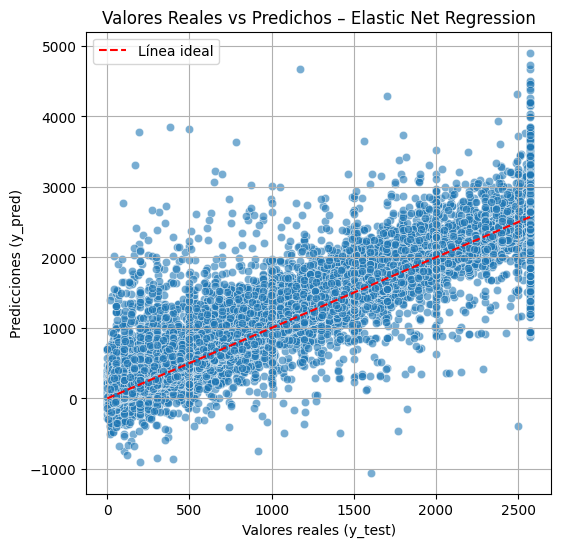

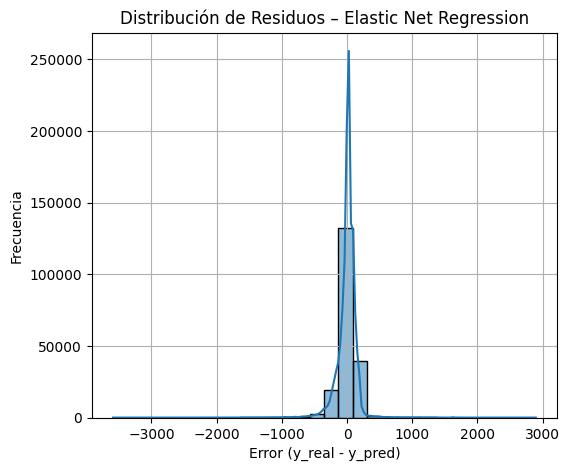

[10/24/25 02:31:36] WARNING  C:\Users\Kevin\AppData\Local\Temp\ipykernel_19476\885296918.py:92:     ]8;id=575518;file://C:\Python313\Lib\warnings.py\warnings.py]8;;\:]8;id=164748;file://C:\Python313\Lib\warnings.py#110\110]8;;\
                             FutureWarning:                                                                        
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               sns.barplot(data=coef_df, x="Coeficiente", y="Variable",                            
                             palette="Blues_r")                                                                    
                                                                                                                   

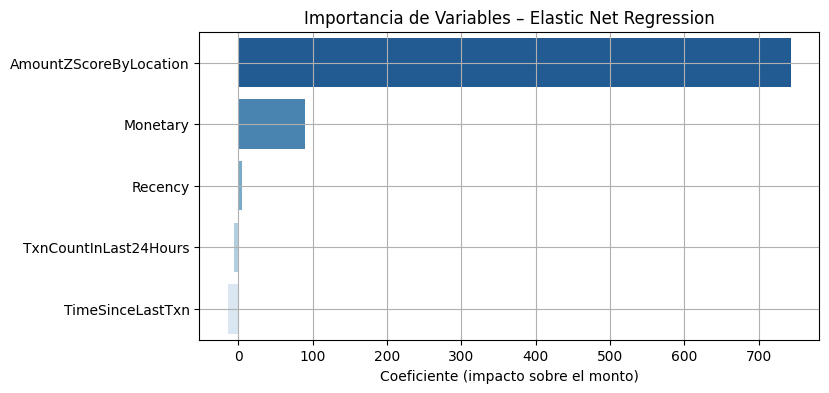


Coeficientes del modelo:
                 Variable  Coeficiente
4  AmountZScoreByLocation   743.958011
0                Monetary    89.608824
2                 Recency     5.293538
3   TxnCountInLast24Hours    -6.241798
1        TimeSinceLastTxn   -14.748249


In [6]:
# =========================================================
# 3️⃣ División Train/Test + Estandarización
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================================================
# 4️⃣ Definir modelo ElasticNet + GridSearchCV
# =========================================================
elastic = ElasticNet(max_iter=5000)

param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1],
    "l1_ratio": [0.2, 0.5, 0.8]  # mezcla entre L1 y L2
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_elastic = GridSearchCV(
    elastic,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1
)

# =========================================================
# 5️⃣ Entrenamiento con validación cruzada
# =========================================================
grid_elastic.fit(X_train_scaled, y_train)

print("Mejores parámetros:", grid_elastic.best_params_)
print("R² medio (CV):", grid_elastic.best_score_)

# =========================================================
# 6️⃣ Evaluación final
# =========================================================
best_elastic = grid_elastic.best_estimator_

y_pred = best_elastic.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("\n===== Métricas del Modelo Elastic Net =====")
print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# =========================================================
# 7️⃣ Gráficos de evaluación
# =========================================================

# 🎯 a) Valores reales vs predichos
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', label='Línea ideal')
plt.title("Valores Reales vs Predichos – Elastic Net Regression")
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.legend()
plt.grid(True)
plt.show()

# 🎯 b) Distribución de residuos
residuals = y_test - y_pred
plt.figure(figsize=(6,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribución de Residuos – Elastic Net Regression")
plt.xlabel("Error (y_real - y_pred)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# 🎯 c) Coeficientes del modelo
coef_df = pd.DataFrame({
    "Variable": features,
    "Coeficiente": best_elastic.coef_
}).sort_values(by="Coeficiente", ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=coef_df, x="Coeficiente", y="Variable", palette="Blues_r")
plt.title("Importancia de Variables – Elastic Net Regression")
plt.xlabel("Coeficiente (impacto sobre el monto)")
plt.ylabel("")
plt.grid(True)
plt.show()

print("\nCoeficientes del modelo:")
print(coef_df)


El modelo Elastic Net Regression, con los parámetros óptimos α = 0.0001 y l1_ratio = 0.8, obtuvo un desempeño prácticamente equivalente a los modelos previos, con R² = 0.966 y MSE = 23 692.46, lo que confirma la consistencia de los resultados y la estabilidad del conjunto de datos frente a diferentes regularizaciones. Aunque la mejora en las métricas numéricas es mínima, el Elastic Net logra equilibrar los efectos de las penalizaciones L1 y L2, manteniendo el excelente ajuste del modelo lineal y, al mismo tiempo, reduciendo ligeramente la varianza de los coeficientes. Los gráficos y_real vs y_pred y de residuos reafirman que las predicciones se distribuyen de forma muy próxima a la línea ideal, sin evidencia de sobreajuste ni heterocedasticidad significativa.

Desde la perspectiva interpretativa, los coeficientes confirman el mismo patrón observado en los modelos anteriores: AmountZScoreByLocation continúa siendo la variable más influyente en el valor de la transacción, seguida por Monetary, mientras que Recency, TxnCountInLast24Hours y TimeSinceLastTxn aportan una influencia marginal o negativa. La combinación de penalizaciones permitió mantener un modelo parsimonioso, estable y explicativo, lo que refuerza la robustez del enfoque lineal para predecir el monto de gasto futuro. En resumen, aunque las métricas no mejoran numéricamente, Elastic Net consolida la estabilidad del modelo y constituye una versión regularizada más resistente a variaciones o correlaciones internas entre las variables.